# Time Series Forecasting using LSTMs
***
**_Brian Griner_**

3.25.18

**Central NJ Deep Learning Meetup** 

Tigerlabs, Princeton NJ
***
Long Short-Term Memory networks (LSTMs) are a special type of Recurrent Neural Network (RNN) specifically designed to capture long-term correlations in a sequence without producing the technical issues of vanishing or exploding gradients during training associated with RNNs. Other benefits of LSTMs for sequence prediction are:
1. Internal memory state that can learn the temporal structure of the inputs
2. Ability to learn multiple parallel input sequences separately
3. Does't require a fixed window for input/output sequences like a multilayer perceptron (MLP)
***
**What is an LSTM?**
An LSTM network consists of sequential **Memory Blocks** composed of three sets of **weights** and **gates**:

**Weights**
1. Input weights
2. Output weights
3. _Internal State_ (Cell state)

**Gates**
1. _Forget_ gate
2. Input gate
3. Output gate

The Memory Block of an LSTM learns the temporal structure of the inputs through its _gates_ that takes the output of the previous block and the inputs at time t-1 and uses gates to create the current state at time t as shown in the diagram below. 

![](https://cdn-images-1.medium.com/max/1600/1*laH0_xXEkFE0lKJu54gkFQ.png) 

In an LSTM, sequence learning is a process of deconstructing the cell state by:
1. _Forgetting_ parts of previous inputs and states
2. Updating the prior cell state to use as _inputs_ to create the current cell state
3. Generating the _output_ sequence and updating the current cell state


For a step by step description of how the LSTM Memory Blocks function see the blog post [Understanding LSTM and its diagrams](https://medium.com/mlreview/understanding-lstm-and-its-diagrams-37e2f46f1714)
***
The special architecture of the LSTM designed to remember single events over a long, unknown time periods makes it an interesting choice for forecasting complex time series. This post explores the potential of LSTMs for different types of time series data. 

### 3 year Monthly Shampoo Sales Data

The first time series examined is a univariate monthly sales data for shampoo provided by
[DataMarket: Time Series Data Library (citing: Makridakis, Wheelwright and Hyndman (1998))](https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-year-period#!ds=22r0&display=line).


Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: shampooSales, dtype: float64


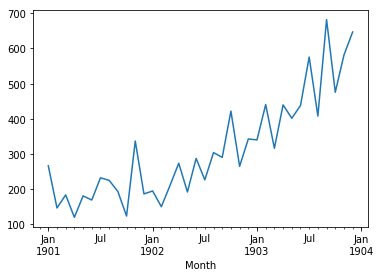

In [1]:
%matplotlib inline

# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
# load dataset
datafile = 'Month-shampooSales.csv'
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv(datafile, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()

# Persistence Model Forecast

EXPLAIN WHAT THE PERSISTENCE MODEL FORECAST IS

RMSE: 136.761


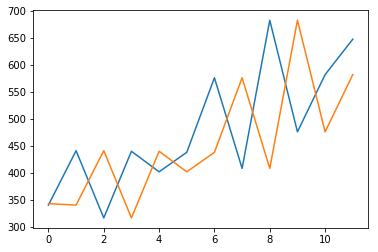

In [2]:
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
# load dataset
datafile = 'Month-shampooSales.csv'
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv(datafile, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# split data into train and test
X = series.values
train, test = X[0:-12], X[-12:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# make prediction
	predictions.append(history[-1])
	# observation
	history.append(test[i])
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()

### RMSE: 136.761

The persistence forecast uses the naive modeling assumption that what happened before will happen again. This is shown clearly in the chart above by the orange line shifting the actual time trend forward one period.

### LSTM data prep

PROVIDE A BRIEF OVERVIEW OF THE STEPS REQUIRED TO PREP TIME SERIES DATA FOR USE IN AN LSTM.

In [3]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat

# frame a sequence as a supervised learning problem
# FROM STACKED T IN ROWS TO T IN COLUMNS?
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# load dataset
datafile = 'Month-shampooSales.csv'
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv(datafile, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# transform to supervised learning
X = series.values
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

       0      0
0    0.0  266.0
1  266.0  145.9
2  145.9  183.1
3  183.1  119.3
4  119.3  180.3


### Transform Time Series to Stationary

In [4]:
from pandas import read_csv
from pandas import datetime
from pandas import Series

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load dataset
datafile = 'Month-shampooSales.csv'
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv(datafile, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
# transform to be stationary
differenced = difference(series, 1)
print(differenced.head())
# invert transform
inverted = list()
for i in range(len(differenced)):
	value = inverse_difference(series, differenced[i], len(series)-i)
	inverted.append(value)
inverted = Series(inverted)
print(inverted.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: shampooSales, dtype: float64
0   -120.1
1     37.2
2    -63.8
3     61.0
4    -11.8
dtype: float64
0    145.9
1    183.1
2    119.3
3    180.3
4    168.5
dtype: float64


### Transform Time Series to Scale

In [5]:
from pandas import read_csv
from pandas import datetime
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
# load dataset
datafile = 'Month-shampooSales.csv'
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv(datafile, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
# transform scale
X = series.values
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)
scaled_series = Series(scaled_X[:, 0])
print(scaled_series.head())
# invert transform
inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = Series(inverted_X[:, 0])
print(inverted_series.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: shampooSales, dtype: float64
0   -0.478585
1   -0.905456
2   -0.773236
3   -1.000000
4   -0.783188
dtype: float64
0    266.0
1    145.9
2    183.1
3    119.3
4    180.3
dtype: float64


# LSTM Model Development - notes on Univariate time series

1. LSTM is 'stateful' like state-space model 
 Benefit: 
  a. Can learn and remember over long sequences
  b. Doesn't require pre-specified window of lagged observations as inputs

2. LSTM layer in Keras maintains state between data within a batch, i.e., a fixed-sized number of rows from the training dataset that defines how many patterns to process before updating the weights of the network

3. State in the LSTM layer between batches is cleared by default, therefore must make the LSTM stateful to provide fine-grained control over when state of the LSTM layer is cleared by calling the reset_states() function

4. The LSTM layer expects input to be in a matrix with the dimensions: [samples, time steps, features]
 a. Samples: These are independent observations from the domain, typically rows of data
 b. Time steps: These are separate time steps of a given variable for a given observation
 c. Features: These are separate measures observed at the time of observation

5. Shape of input data must be specified in LSTM layer using “batch_input_shape” argument as tuple that specifies: 
 a. expected number of observations to read each batch 
 b. number of time steps
 c. number of features

6. Batch size is often much smaller than total number of samples and along with the number of epochs, defines how quickly then network learns the data; i.e., how often the weights are updated

7. Final import parameter defining the LSTM layer is number of neurons (aka memory units or blocks) usually 1-5

 Example code: 
  layer = LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True)

8. Network requires single neuron in output layer using a linear activation function to predict the number of shampoo sales at the next time step
9. Network specification then compiled in TF using a specific loss function and optimization algorithm: 
 a. Use “mean_squared_error” as the loss function (matches RMSE) 
 b. ADAM optimization algorithm (efficient)
 
 Sequential Keras API example code:
  model = Sequential()
  model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
 
10. Once LSTM is compiled, it can be fit to the training data 
 a. Because the network is stateful, we must control when the internal state is reset; therefore, must manually manage training process one epoch at a time across desired number of epochs

11. By default, the samples within an epoch are shuffled prior to being exposed to the network which is undesirable for the Time-Series LSTM because we want the network to build up state as it learns across the sequence of observations (can disable shuffling of samples by setting “shuffle” to “False“)

12. By default, network reports lots of debug info about learning progress and skill of model at end of each epoch. Can disable by setting the “verbose” argument to “0“

 Example code: loop manually fits network to the training data
  for i in range(nb_epoch):	
   model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
   model.reset_states()
   
13. batch_size must be set to 1. This is because it must be a factor of the size of the training and test datasets

14. The predict() function for model also constrained by batch size; therefore, must be set to 1 because we are interested in making one-step forecasts on the test data

15. Network parameters not tuned in tutorial code; instead use the following configuration, found with a little trial and error:

 Batch Size: 1
 Epochs: 3000
 Neurons: 4
 
 Consider trying 1500 epochs and 1 neuron, the performance may be better!

## LSTM Univariate Forecast of Shampoo Sales

/Users/briangriner/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/briangriner/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Month=1, Predicted=334.216018, Expected=339.700000
Month=2, Predicted=354.086088, Expected=440.400000
Month=3, Predicted=365.082124, Expected=315.900000
Month=4, Predicted=394.578410, Expected=439.300000
Month=5, Predicted=366.498817, Expected=401.300000
Month=6, Predicted=452.597413, Expected=437.400000
Month=7, Predicted=463.355654, Expected=575.500000
Month=8, Predicted=435.881582, Expected=407.600000
Month=9, Predicted=482.459920, Expected=682.000000
Month=10, Predicted=495.308746, Expected=475.300000
Month=11, Predicted=579.637990, Expected=581.300000
Month=12, Predicted=518.808544, Expected=646.900000
Test RMSE: 83.339


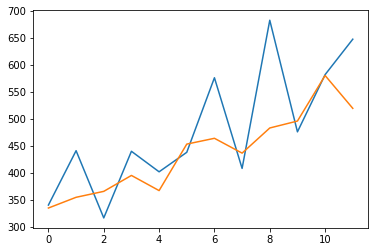

In [6]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
datafile = 'Month-shampooSales.csv'
series = read_csv(datafile, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

## Persistence LSTM Multi-Step Forecast of Shampoo Sales

t+1 RMSE: 144.535304
t+2 RMSE: 86.479905
t+3 RMSE: 121.149168


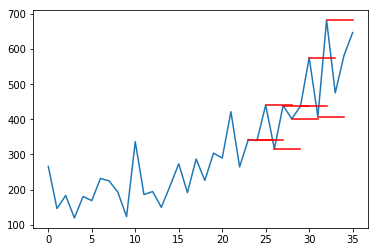

In [9]:
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	raw_values = raw_values.reshape(len(raw_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(raw_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return train, test

# make a persistence forecast
def persistence(last_ob, n_seq):
	return [last_ob for i in range(n_seq)]

# evaluate the persistence model
def make_forecasts(train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = persistence(X[-1], n_seq)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = test[:,(n_lag+i)]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

# load dataset
datafile = 'Month-shampooSales.csv'
series = read_csv(datafile, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# configure
n_lag = 1
n_seq = 3
n_test = 10
# prepare data
train, test = prepare_data(series, n_test, n_lag, n_seq)
# make forecasts
forecasts = make_forecasts(train, test, n_lag, n_seq)
# evaluate forecasts
evaluate_forecasts(test, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)

**RMSE for PERSISTENCE Forecast**

t+1 RMSE: 144.535304

t+2 RMSE: 86.479905

t+3 RMSE: 121.149168
***
## Multi-Step LSTM Network Forecast of Shampoo Sales

t+1 RMSE: 96.559530
t+2 RMSE: 79.352093
t+3 RMSE: 109.033138


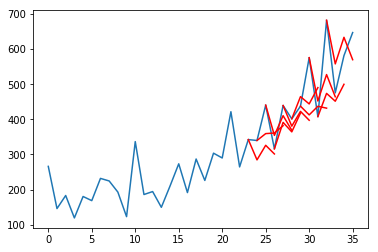

In [10]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

# load dataset
datafile = 'Month-shampooSales.csv'
series = read_csv(datafile, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# configure
n_lag = 1
n_seq = 3
n_test = 10
n_epochs = 1500
n_batch = 1
n_neurons = 1
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)

**Full multi-step LSTM improves RSME over the Persistence forecast.**

t+1 RMSE: 96.559530

t+2 RMSE: 79.352093

t+3 RMSE: 109.033138
***
**LSTM extensions to improve forecasting results.**

 1. Update LSTM as new data becomes available: A 10s of training epochs should be sufficient to retrain with a new observation
 2. Tune the LSTM: Grid search some of the LSTM parameters used in the tutorial, such as:
  a. number of epochs
  b. number of neurons
  c. number of layers 
 3. Seq2Seq: Use the encoder-decoder paradigm for LSTMs to forecast each sequence to see if this offers any benefit.
 4. Change Time Horizons: 
  a. Experiment with forecasting different time horizons
  b. Experiment with different lead times

6. Repeats vs Test RMSE
 q. We can start to look at how the summary statistics for the experiment change as the number of repeats is increased from 1 to 100.
 r. We can accumulate the test RMSE scores and calculate descriptive statistics. For example, the score from one repeat, the scores from the first and second repeats, the scores from the first 3 repeats, and so on to 100 repeats.
 s. We can review how the central tendency changes as the number of repeats is increased as a line plot. We’ll look at both the mean and median.
 t. Generally, we would expect that as the number of repeats of the experiment is increased, the distribution would increasingly better match the underlying distribution, including the central tendency, such as the mean.

1 99.9371600625 99.9371600625
2 97.3526858528 97.3526858528
3 95.7116703142 94.7682116432
4 98.1972922233 97.3526858528
5 98.1736376285 98.0790192495
6 104.916939944 99.008089656
7 104.042383772 98.7950467433
8 103.855486942 99.3661034029
9 103.912818007 99.9371600625
10 103.263322738 99.3661034029
11 102.807119382 98.7950467433
12 102.699684215 99.3661034029
13 102.899405999 99.9371600625
14 102.539343071 99.3661034029
15 102.194923555 98.7950467433
16 102.264475909 99.3661034029
17 102.008937912 98.7950467433
18 101.780667932 98.5200662815
19 101.642177306 98.7950467433
20 101.575067349 98.9721963973
21 101.173116342 98.7950467433
22 101.112452184 98.9721963973
23 100.817897067 98.7950467433
24 101.256344389 98.9721963973
25 101.253508905 99.1493460513
26 101.688477852 99.4939254566
27 101.634988696 99.8385048619
28 102.064856621 99.8878324622
29 102.014515519 99.9371600625
30 101.805118949 99.8878324622
31 101.786293553 99.9371600625
32 101.838982794 100.090715354
33 102.037008478 1

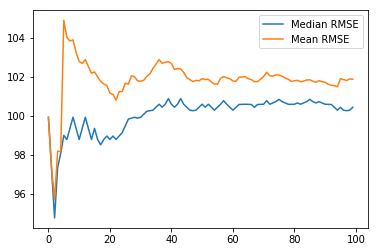

In [3]:
from pandas import DataFrame
from pandas import read_csv
from numpy import median
from numpy import mean
from matplotlib import pyplot
import numpy
# load results file
results = read_csv('experiment_stateful.csv', header=0)
values = results.values
# collect cumulative stats
medians, means = list(), list()
for i in range(1,len(values)+1):
	data = values[0:i, 0]
	mean_rmse, median_rmse = mean(data), median(data)
	means.append(mean_rmse)
	medians.append(median_rmse)
	print(i, mean_rmse, median_rmse)
# line plot of cumulative values
line1, = pyplot.plot(medians, label='Median RMSE')
line2, = pyplot.plot(means, label='Mean RMSE')
pyplot.legend(handles=[line1, line2])
pyplot.show()

7. Review of Results
 We made some useful observations from 100 repeats of a stateful LSTM on a standard time series forecasting problem.
 Specifically:
 w. We observed that the distribution of results is not Gaussian. It may be a skewed Gaussian or an exponential distribution with a long tail and outliers.
 x. We observed that the distribution of results did not stabilize with the increase of repeats from 1 to 100.

 z. The observations suggest a few important properties:
  i. The choice of online learning for the LSTM and problem results in a relatively unstable model.
  ii. The chosen number of repeats (100) may not be sufficient to characterize the behavior of the model. This is a useful finding as it would be a mistake to make strong conclusions about the model from 100 or fewer repeats of the experiment. This is an important caution to consider when describing your own machine learning results.

 This suggests some extensions to this experiment, such as:
 iii. Explore the impact of the number of repeats on a more stable model, such as one using batch or mini-batch learning.
 iv. Increase the number of repeats to thousands or more in an attempt to account for the general instability of the model with online learning.

## LSTM Feature Selection Using Variable Lagged Inputs 

In [2]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# run a repeated experiment
def experiment(repeats, series, features):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, features)
	supervised_values = supervised.values[features:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the base model
		lstm_model = fit_lstm(train_scaled, 1, 500, 1)
		# forecast test dataset
		predictions = list()
		for i in range(len(test_scaled)):
			# predict
			X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
			yhat = forecast_lstm(lstm_model, 1, X)
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

# execute the experiment
def run():
	# load dataset
	series = read_csv('Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# experiment
	repeats = 10
	results = DataFrame()
	# run experiment
	features = 1
	results['results'] = experiment(repeats, series, features)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment_features_1.csv', index=False)

 # entry point
run()

/Users/briangriner/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/briangriner/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


1) Test RMSE: 104.781
2) Test RMSE: 89.863
3) Test RMSE: 91.596
4) Test RMSE: 107.090
5) Test RMSE: 111.542
6) Test RMSE: 107.548
7) Test RMSE: 107.857
8) Test RMSE: 93.024
9) Test RMSE: 109.091
10) Test RMSE: 115.265
          results
count   10.000000
mean   103.765512
std      8.950142
min     89.862972
25%     95.963043
50%    107.318882
75%    108.782123
max    115.264548


## LSTM Hyper Parameter Tuning

In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df = df.drop(0)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# run a repeated experiment
def experiment(repeats, series, epochs):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the model
		batch_size = 4
		train_trimmed = train_scaled[2:, :]
		lstm_model = fit_lstm(train_trimmed, batch_size, epochs, 1)
		# forecast the entire training dataset to build up state for forecasting
		train_reshaped = train_trimmed[:, 0].reshape(len(train_trimmed), 1, 1)
		lstm_model.predict(train_reshaped, batch_size=batch_size)
		# forecast test dataset
		test_reshaped = test_scaled[:,0:-1]
		test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
		output = lstm_model.predict(test_reshaped, batch_size=batch_size)
		predictions = list()
		for i in range(len(output)):
			yhat = output[i,0]
			X = test_scaled[i, 0:-1]
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores


# load dataset
series = read_csv('Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# experiment
repeats = 30
results = DataFrame()
# vary training epochs
epochs = [500, 1000, 2000, 4000, 6000]
for e in epochs:
	results[str(e)] = experiment(repeats, series, e)
# summarize results
print(results.describe())
# save boxplot
results.boxplot()
pyplot.savefig('boxplot_epochs.png')

/Users/briangriner/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/briangriner/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


1) Test RMSE: 116.244
2) Test RMSE: 105.167
3) Test RMSE: 107.959
4) Test RMSE: 103.581
5) Test RMSE: 92.860
6) Test RMSE: 116.279
7) Test RMSE: 95.805
8) Test RMSE: 102.630
9) Test RMSE: 97.922
10) Test RMSE: 100.012
11) Test RMSE: 105.333
12) Test RMSE: 132.640
13) Test RMSE: 99.414
14) Test RMSE: 95.083
15) Test RMSE: 129.690
16) Test RMSE: 115.812
17) Test RMSE: 89.469
18) Test RMSE: 109.267
19) Test RMSE: 118.950
20) Test RMSE: 125.883
21) Test RMSE: 92.582
22) Test RMSE: 133.175
23) Test RMSE: 119.913
24) Test RMSE: 99.699
25) Test RMSE: 96.708
26) Test RMSE: 103.053
27) Test RMSE: 133.719
28) Test RMSE: 115.439
29) Test RMSE: 126.229
30) Test RMSE: 107.725
1) Test RMSE: 109.616
2) Test RMSE: 91.144
3) Test RMSE: 136.031
4) Test RMSE: 94.253
5) Test RMSE: 91.445
6) Test RMSE: 97.294
7) Test RMSE: 114.433
8) Test RMSE: 92.412
9) Test RMSE: 124.144
10) Test RMSE: 113.207
11) Test RMSE: 97.311
12) Test RMSE: 91.738
13) Test RMSE: 102.385
14) Test RMSE: 91.028
15) Test RMSE: 113.626


## LSTM With Dropout

In [2]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, n_batch, nb_epoch, n_neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

# run a repeated experiment
def experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, n_lag)
	supervised_values = supervised.values[n_lag:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(n_repeats):
		# fit the model
		train_trimmed = train_scaled[2:, :]
		lstm_model = fit_lstm(train_trimmed, n_batch, n_epochs, n_neurons)
		# forecast test dataset
		test_reshaped = test_scaled[:,0:-1]
		test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
		output = lstm_model.predict(test_reshaped, batch_size=n_batch)
		predictions = list()
		for i in range(len(output)):
			yhat = output[i,0]
			X = test_scaled[i, 0:-1]
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

# configure the experiment
def run():
	# load dataset
	series = read_csv('Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# configure the experiment
	n_lag = 1
	n_repeats = 30
	n_epochs = 1000
	n_batch = 4
	n_neurons = 3
	# run the experiment
	results = DataFrame()
	results['results'] = experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons)
	# summarize results
	print(results.describe())
	# save boxplot
	results.boxplot()
	pyplot.savefig('experiment_baseline.png')

# entry point
run()

1) Test RMSE: 93.227
2) Test RMSE: 98.491
3) Test RMSE: 95.787
4) Test RMSE: 90.360
5) Test RMSE: 95.000
6) Test RMSE: 95.294
7) Test RMSE: 96.418
8) Test RMSE: 105.760
9) Test RMSE: 99.883
10) Test RMSE: 99.894
11) Test RMSE: 96.325
12) Test RMSE: 99.207
13) Test RMSE: 92.950
14) Test RMSE: 92.712
15) Test RMSE: 107.886
16) Test RMSE: 89.614
17) Test RMSE: 96.016
18) Test RMSE: 92.496
19) Test RMSE: 110.336
20) Test RMSE: 89.302
21) Test RMSE: 98.455
22) Test RMSE: 89.617
23) Test RMSE: 92.559
24) Test RMSE: 102.068
25) Test RMSE: 96.993
26) Test RMSE: 98.855
27) Test RMSE: 94.732
28) Test RMSE: 99.665
29) Test RMSE: 96.716
30) Test RMSE: 100.087
          results
count   30.000000
mean    96.890141
std      5.123334
min     89.301675
25%     93.019185
50%     96.371511
75%     99.550252
max    110.336264


In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
	# separate
	X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
	# reshape
	reshaped = X.reshape(len(X), 1, 1)
	# forecast dataset
	output = model.predict(reshaped, batch_size=batch_size)
	# invert data transforms on forecast
	predictions = list()
	for i in range(len(output)):
		yhat = output[i,0]
		# invert scaling
		yhat = invert_scale(scaler, X[i], yhat)
		# invert differencing
		yhat = yhat + raw_data[i]
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
	# reset model state
	model.reset_states()
	return rmse

# fit an LSTM network to training data
def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# prepare model
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit model
	train_rmse, test_rmse = list(), list()
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
		# evaluate model on train data
		raw_train = raw[-(len(train)+len(test)+1):-len(test)]
		train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
		# evaluate model on test data
		raw_test = raw[-(len(test)+1):]
		test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
	history = DataFrame()
	history['train'], history['test'] = train_rmse, test_rmse
	return history

# run diagnostic experiments
def run():
	# config
	n_lag = 1
	n_repeats = 10
	n_epochs = 1000
	n_batch = 4
	n_neurons = 3
	# load dataset
	series = read_csv('Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, n_lag)
	supervised_values = supervised.values[n_lag:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# fit and evaluate model
	train_trimmed = train_scaled[2:, :]
	# run diagnostic tests
	for i in range(n_repeats):
		history = fit_lstm(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
		pyplot.plot(history['train'], color='blue')
		pyplot.plot(history['test'], color='orange')
		print('%d) TrainRMSE=%f, TestRMSE=%f' % (i+1, history['train'].iloc[-1], history['test'].iloc[-1]))
	pyplot.savefig('diagnostic_baseline.png')

# entry point
run()

## LSTM Using Weight Regularization

**Baseline LSTM Model**

Lag inputs: 1

Epochs: 1000

Units in LSTM hidden layer: 3

Batch Size: 4

Repeats: 3

In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.regularizers import L1L2
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, n_batch, nb_epoch, n_neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

# run a repeated experiment
def experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, n_lag)
	supervised_values = supervised.values[n_lag:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(n_repeats):
		# fit the model
		train_trimmed = train_scaled[2:, :]
		lstm_model = fit_lstm(train_trimmed, n_batch, n_epochs, n_neurons)
		# forecast test dataset
		test_reshaped = test_scaled[:,0:-1]
		test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
		output = lstm_model.predict(test_reshaped, batch_size=n_batch)
		predictions = list()
		for i in range(len(output)):
			yhat = output[i,0]
			X = test_scaled[i, 0:-1]
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

# configure the experiment
def run():
	# load dataset
	series = read_csv('Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# configure the experiment
	n_lag = 1
	n_repeats = 30
	n_epochs = 1000
	n_batch = 4
	n_neurons = 3
	# run the experiment
	results = DataFrame()
	results['results'] = experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons)
	# summarize results
	print(results.describe())
	# save boxplot
	results.boxplot()
	pyplot.savefig('experiment_baseline.png')

# entry point
run()

## LSTM Bias Regularization

L1L2(0.0, 0.0) [e.g. baseline]

L1L2(0.01, 0.0) [e.g. L1]

L1L2(0.0, 0.01) [e.g. L2]

L1L2(0.01, 0.01) [e.g. L1L2 or elasticnet]

In [ ]:
# fit an LSTM network to training data
def fit_lstm(train, n_batch, nb_epoch, n_neurons, reg):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, bias_regularizer=reg))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

# run a repeated experiment
def experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons, reg):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, n_lag)
	supervised_values = supervised.values[n_lag:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(n_repeats):
		# fit the model
		train_trimmed = train_scaled[2:, :]
		lstm_model = fit_lstm(train_trimmed, n_batch, n_epochs, n_neurons, reg)
		# forecast test dataset
		test_reshaped = test_scaled[:,0:-1]
		test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
		output = lstm_model.predict(test_reshaped, batch_size=n_batch)
		predictions = list()
		for i in range(len(output)):
			yhat = output[i,0]
			X = test_scaled[i, 0:-1]
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

# configure the experiment
def run():
	# load dataset
	series = read_csv(# fit an LSTM network to training data
def fit_lstm(train, n_batch, nb_epoch, n_neurons, reg):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, bias_regularizer=reg))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

# run a repeated experiment
def experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons, reg):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, n_lag)
	supervised_values = supervised.values[n_lag:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(n_repeats):
		# fit the model
		train_trimmed = train_scaled[2:, :]
		lstm_model = fit_lstm(train_trimmed, n_batch, n_epochs, n_neurons, reg)
		# forecast test dataset
		test_reshaped = test_scaled[:,0:-1]
		test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
		output = lstm_model.predict(test_reshaped, batch_size=n_batch)
		predictions = list()
		for i in range(len(output)):
			yhat = output[i,0]
			X = test_scaled[i, 0:-1]
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

# configure the experiment
def run():
	# load dataset
	series = read_csv('Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# configure the experiment
	n_lag = 1
	n_repeats = 30
	n_epochs = 1000
	n_batch = 4
	n_neurons = 3
	regularizers = [L1L2(l1=0.0, l2=0.0), L1L2(l1=0.01, l2=0.0), L1L2(l1=0.0, l2=0.01), L1L2(l1=0.01, l2=0.01)]
	# run the experiment
	results = DataFrame()
	for reg in regularizers:
		name = ('l1 %.2f,l2 %.2f' % (reg.l1, reg.l2))
		results[name] = experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons, reg)
	# summarize results
	print(results.describe())
	# save boxplot
	results.boxplot()
	pyplot.savefig('experiment_reg_bias.png'), header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# configure the experiment
	n_lag = 1
	n_repeats = 30
	n_epochs = 1000
	n_batch = 4
	n_neurons = 3
	regularizers = [L1L2(l1=0.0, l2=0.0), L1L2(l1=0.01, l2=0.0), L1L2(l1=0.0, l2=0.01), L1L2(l1=0.01, l2=0.01)]
	# run the experiment
	results = DataFrame()
	for reg in regularizers:
		name = ('l1 %.2f,l2 %.2f' % (reg.l1, reg.l2))
		results[name] = experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons, reg)
	# summarize results
	print(results.describe())
	# save boxplot
	results.boxplot()
	pyplot.savefig('experiment_reg_bias.png')

## LSTM Input Weight Regularization

L1L2(0.0, 0.0) [e.g. baseline]

L1L2(0.01, 0.0) [e.g. L1]

L1L2(0.0, 0.01) [e.g. L2]

L1L2(0.01, 0.01) [e.g. L1L2 or elasticnet]

In [ ]:
# fit an LSTM network to training data
def fit_lstm(train, n_batch, nb_epoch, n_neurons, reg):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, kernel_regularizer=reg))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

# run a repeated experiment
def experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons, reg):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, n_lag)
	supervised_values = supervised.values[n_lag:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(n_repeats):
		# fit the model
		train_trimmed = train_scaled[2:, :]
		lstm_model = fit_lstm(train_trimmed, n_batch, n_epochs, n_neurons, reg)
		# forecast test dataset
		test_reshaped = test_scaled[:,0:-1]
		test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
		output = lstm_model.predict(test_reshaped, batch_size=n_batch)
		predictions = list()
		for i in range(len(output)):
			yhat = output[i,0]
			X = test_scaled[i, 0:-1]
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

# configure the experiment
def run():
	# load dataset
	series = read_csv('Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# configure the experiment
	n_lag = 1
	n_repeats = 30
	n_epochs = 1000
	n_batch = 4
	n_neurons = 3
	regularizers = [L1L2(l1=0.0, l2=0.0), L1L2(l1=0.01, l2=0.0), L1L2(l1=0.0, l2=0.01), L1L2(l1=0.01, l2=0.01)]
	# run the experiment
	results = DataFrame()
	for reg in regularizers:
		name = ('l1 %.2f,l2 %.2f' % (reg.l1, reg.l2))
		results[name] = experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons, reg)
	# summarize results
	print(results.describe())
	# save boxplot
	results.boxplot()
	pyplot.savefig('experiment_reg_input.png')

## LSTM Recurrent Weight Regularization

L1L2(0.0, 0.0) [e.g. baseline]

L1L2(0.01, 0.0) [e.g. L1]

L1L2(0.0, 0.01) [e.g. L2]

L1L2(0.01, 0.01) [e.g. L1L2 or elasticnet]

In [ ]:
# fit an LSTM network to training data
def fit_lstm(train, n_batch, nb_epoch, n_neurons, reg):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, recurrent_regularizer=reg))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

# run a repeated experiment
def experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons, reg):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, n_lag)
	supervised_values = supervised.values[n_lag:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(n_repeats):
		# fit the model
		train_trimmed = train_scaled[2:, :]
		lstm_model = fit_lstm(train_trimmed, n_batch, n_epochs, n_neurons, reg)
		# forecast test dataset
		test_reshaped = test_scaled[:,0:-1]
		test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
		output = lstm_model.predict(test_reshaped, batch_size=n_batch)
		predictions = list()
		for i in range(len(output)):
			yhat = output[i,0]
			X = test_scaled[i, 0:-1]
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

# configure the experiment
def run():
	# load dataset
	series = read_csv('Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# configure the experiment
	n_lag = 1
	n_repeats = 30
	n_epochs = 1000
	n_batch = 4
	n_neurons = 3
	regularizers = [L1L2(l1=0.0, l2=0.0), L1L2(l1=0.01, l2=0.0), L1L2(l1=0.0, l2=0.01), L1L2(l1=0.01, l2=0.01)]
	# run the experiment
	results = DataFrame()
	for reg in regularizers:
		name = ('l1 %.2f,l2 %.2f' % (reg.l1, reg.l2))
		results[name] = experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons, reg)
	# summarize results
	print(results.describe())
	# save boxplot
	results.boxplot()
	pyplot.savefig('experiment_reg_recurrent.png')

# Instability of Online Learning for Stateful LSTM for Time Series Forecasting

1. Setup Experiment
 a. Data Split: We will split the Shampoo Sales dataset into two parts: a training and a test set. The first two years of data will be taken for the training dataset and the remaining one year of data will be used for the test set.
 b. Models will be developed using the training dataset and will make predictions on the test dataset.
 c. The persistence forecast (naive forecast) on the test dataset achieves an error of 136.761 monthly shampoo sales. This provides a lower acceptable bound of performance on the test set.

2. Model Evaluation
 d. A rolling-forecast scenario will be used, also called walk-forward model validation. Each time step of the test dataset will be walked one at a time. A model will be used to make a forecast for the time step, then the actual expected value from the test set will be taken and made available to the model for the forecast on the next time step.
 e. All forecasts on the test dataset will be collected and an error score calculated to summarize the skill of the model. The root mean squared error (RMSE) will be used as it punishes large errors and results in a score that is in the same units as the forecast data, namely monthly shampoo sales.

3. Data Preparation & Transformations
 f. Transform the time series data so that it is stationary. Specifically a lag=1 differencing to remove the increasing trend in the data.
 g. Transform the time series into a supervised learning problem. Specifically the organization of data into input and output patterns where the observation at the previous time step is used as an input to forecast the observation at the current time step
 h. Transform the observations to have a specific scale. Specifically, to rescale the data to values between -1 and 1 to meet the default hyperbolic tangent activation function of the LSTM model.
 i. These transforms are inverted on forecasts to return them into their original scale before calculating and error score.

4. LSTM Model
 j. We will use a base stateful LSTM model with 1 neuron fit for 1000 epochs.
 k. A batch size of 1 is required as we will be using walk-forward validation and making one-step forecasts for each of the final 12 months of test data.
 l.A batch size of 1 means that the model will be fit using online training (as opposed to batch training or mini-batch training). As a result, it is expected that the model fit will have some variance.
 m. Ideally, more training epochs would be used (such as 1500), but this was truncated to 1000 to keep run times reasonable.
 n. The model will be fit using the efficient ADAM optimization algorithm and the mean squared error loss function.

5. Experimental Runs
 o. Each experimental scenario will be run 100 times and the RMSE score on the test set will be recorded from the end each run.
 p. All test RMSE scores are written to file for later analysis.

In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# run a repeated experiment
def experiment(repeats, series):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values[1:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the base model
		lstm_model = fit_lstm(train_scaled, 1, 1000, 1)
		# forecast test dataset
		predictions = list()
		for i in range(len(test_scaled)):
			# predict
			X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
			yhat = forecast_lstm(lstm_model, 1, X)
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

# execute the experiment
def run():
	# load dataset
	series = read_csv('Month-shampooSales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# experiment
	repeats = 100
	results = DataFrame()
	# run experiment
	results['results'] = experiment(repeats, series)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment_stateful.csv', index=False)

 # entry point
run()

6. Repeats vs Test RMSE

 q. We can start to look at how the summary statistics for the experiment change as the number of repeats is increased from 1 to 100.
 
 r. We can accumulate the test RMSE scores and calculate descriptive statistics. For example, the score from one repeat, the scores from the first and second repeats, the scores from the first 3 repeats, and so on to 100 repeats.
 
 s. We can review how the central tendency changes as the number of repeats is increased as a line plot. We’ll look at both the mean and median.
 
 t. Generally, we would expect that as the number of repeats of the experiment is increased, the distribution would increasingly better match the underlying distribution, including the central tendency, such as the mean.